# ============================================
# IMPORT LIBRARIES
# ============================================

In [1]:
import numpy as np
import pandas as pd

import re
import string

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD  # PCA-like dimensionality reduction for sparse data
from sklearn.preprocessing import StandardScaler, LabelBinarizer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    log_loss
)

import joblib  # for saving the model and transformers

import warnings
warnings.filterwarnings("ignore")

# ============================================
# LOAD DATASET
# ============================================

In [2]:
DATA_PATH = "labeled_data.csv"

df = pd.read_csv(DATA_PATH)

print("First 5 rows:")
print(df.head())

print("\nDataset shape:", df.shape)

print("\nColumns:")
print(df.columns)

First 5 rows:
   Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0           0      3            0                   0        3      2   
1           1      3            0                   3        0      1   
2           2      3            0                   3        0      1   
3           3      3            0                   2        1      1   
4           4      6            0                   6        0      1   

                                               tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't...  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...  

Dataset shape: (24783, 7)

Columns:
Index(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither',
       'class', 'tweet'],
      dtype='object')


# ============================================
# BASIC DATA EXPLORATION
# ============================================

In [3]:
print("\nInfo:")
print(df.info())


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB
None


In [4]:
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
Unnamed: 0            0
count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
dtype: int64


In [5]:
print("\nClass distribution (0 = hate, 1 = offensive, 2 = neither):")
print(df['class'].value_counts())


Class distribution (0 = hate, 1 = offensive, 2 = neither):
class
1    19190
2     4163
0     1430
Name: count, dtype: int64


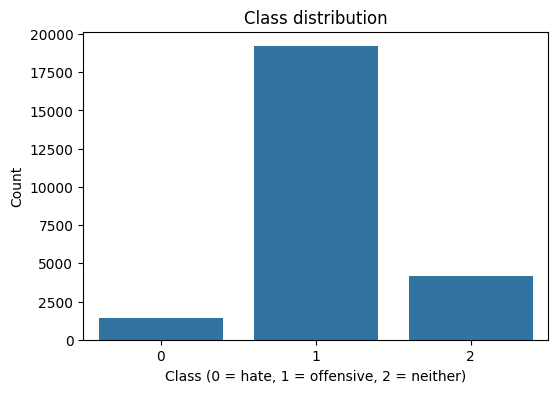

In [6]:
# Visualise class distribution
plt.figure(figsize=(6,4))
sns.countplot(x='class', data=df)
plt.title("Class distribution")
plt.xlabel("Class (0 = hate, 1 = offensive, 2 = neither)")
plt.ylabel("Count")
plt.show()

In [7]:
# Check basic statistics of numeric columns
print("\nNumeric columns description:")
print(df[['count', 'hate_speech', 'offensive_language', 'neither']].describe())


Numeric columns description:
              count   hate_speech  offensive_language       neither
count  24783.000000  24783.000000        24783.000000  24783.000000
mean       3.243473      0.280515            2.413711      0.549247
std        0.883060      0.631851            1.399459      1.113299
min        3.000000      0.000000            0.000000      0.000000
25%        3.000000      0.000000            2.000000      0.000000
50%        3.000000      0.000000            3.000000      0.000000
75%        3.000000      0.000000            3.000000      0.000000
max        9.000000      7.000000            9.000000      9.000000


# ============================================
# TEXT PRE-PROCESSING
# ============================================

In [8]:
def clean_text(text):
    # Convert to string in case of any non-string values
    text = str(text)
    # Lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    # Remove mentions and hashtags
    text = re.sub(r"@\w+|#\w+", "", text)
    # Remove HTML entities like &amp;
    text = re.sub(r"&\w+;", " ", text)
    # Remove digits
    text = re.sub(r"\d+", "", text)
    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Apply cleaning
df['clean_tweet'] = df['tweet'].apply(clean_text)

print("Original tweet:")
print(df['tweet'].iloc[0])
print("\nCleaned tweet:")
print(df['clean_tweet'].iloc[0])

Original tweet:
!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...

Cleaned tweet:
rt as a woman you shouldnt complain about cleaning up your house as a man you should always take the trash out


# ============================================
# FEATURE ENGINEERING: LENGTH FEATURE + OUTLIER HANDLING
# ============================================


Tweet length statistics:
count    24783.000000
mean        62.335916
std         32.912639
min          0.000000
25%         36.000000
50%         57.000000
75%         88.000000
max        140.000000
Name: tweet_length, dtype: float64


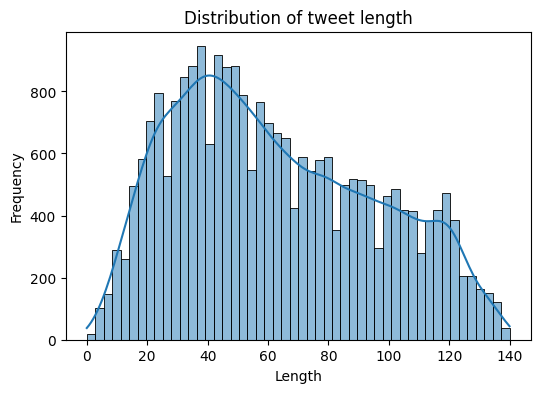

In [9]:
df['tweet_length'] = df['clean_tweet'].apply(len)

print("\nTweet length statistics:")
print(df['tweet_length'].describe())

# Plot distribution of tweet length
plt.figure(figsize=(6,4))
sns.histplot(df['tweet_length'], bins=50, kde=True)
plt.title("Distribution of tweet length")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()

In [10]:
low_quantile = df['tweet_length'].quantile(0.05)
high_quantile = df['tweet_length'].quantile(0.95)

print("\nOutlier thresholds for tweet length:")
print("Low threshold:", low_quantile)
print("High threshold:", high_quantile)

df_filtered = df[(df['tweet_length'] >= low_quantile) & (df['tweet_length'] <= high_quantile)].copy()

print("\nShape before outlier removal:", df.shape)
print("Shape after outlier removal:", df_filtered.shape)

# We will use df_filtered for modelling
df = df_filtered.reset_index(drop=True)


Outlier thresholds for tweet length:
Low threshold: 16.0
High threshold: 121.0

Shape before outlier removal: (24783, 9)
Shape after outlier removal: (22533, 9)


# ============================================
# DEFINE FEATURES (X) AND TARGET (y)
# ============================================

In [11]:
# Target is the 'class' column: 0 = hate, 1 = offensive, 2 = neither
y = df['class']

# Text feature
text_data = df['clean_tweet']

# Numeric feature: tweet_length (we can include more numeric features if needed)
numeric_features = df[['tweet_length']]

print("Text samples:")
print(text_data.head())

print("\nTarget samples:")
print(y.head())

Text samples:
0    rt as a woman you shouldnt complain about clea...
1    rt boy dats coldtyga dwn bad for cuffin dat ho...
2    rt dawg rt you ever fuck a bitch and she start...
3                            rt she look like a tranny
4    rt the shit you hear about me might be true or...
Name: clean_tweet, dtype: object

Target samples:
0    2
1    1
2    1
3    1
4    1
Name: class, dtype: int64


# ============================================
# TRAIN-TEST SPLIT
# ============================================

In [12]:
X_train_text, X_test_text, X_train_num, X_test_num, y_train, y_test = train_test_split(
    text_data,
    numeric_features,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", X_train_text.shape[0])
print("Test size:", X_test_text.shape[0])

Train size: 18026
Test size: 4507


# ============================================
# TF-IDF VECTORISATION (FEATURE EXTRACTION)
# ============================================

In [13]:
tfidf = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1,2),
    min_df=5
)

X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf = tfidf.transform(X_test_text)

print("TF-IDF train shape:", X_train_tfidf.shape)
print("TF-IDF test shape:", X_test_tfidf.shape)

TF-IDF train shape: (18026, 8522)
TF-IDF test shape: (4507, 8522)


# ============================================
# DIMENSIONALITY REDUCTION USING TRUNCATED SVD (PCA-LIKE)
# ============================================

In [14]:
n_components = 200  # you can adjust this (e.g., 100, 200, 300)

svd = TruncatedSVD(n_components=n_components, random_state=42)
X_train_svd = svd.fit_transform(X_train_tfidf)
X_test_svd = svd.transform(X_test_tfidf)

print("SVD-reduced train shape:", X_train_svd.shape)
print("SVD-reduced test shape:", X_test_svd.shape)

SVD-reduced train shape: (18026, 200)
SVD-reduced test shape: (4507, 200)


In [15]:
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

In [16]:
from scipy.sparse import hstack
# Note: SVD outputs dense arrays; numeric scaled is dense. We can use np.hstack.
X_train_final = np.hstack([X_train_svd, X_train_num_scaled])
X_test_final = np.hstack([X_test_svd, X_test_num_scaled])

print("Final train feature shape:", X_train_final.shape)
print("Final test feature shape:", X_test_final.shape)

Final train feature shape: (18026, 201)
Final test feature shape: (4507, 201)


# ============================================
# BASELINE MODEL SELECTION AND TRAINING
# ============================================

In [17]:
models = {
    "MultinomialNB": MultinomialNB(),
    "LogisticRegression": LogisticRegression(max_iter=1000, multi_class="multinomial"),
    "LinearSVC": LinearSVC(),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42)
}


In [18]:
baseline_results = []

for name, model in models.items():
    # Note: MultinomialNB expects non-negative features, works better with raw TF-IDF
    if name == "MultinomialNB":
        model.fit(X_train_tfidf, y_train)
        y_pred = model.predict(X_test_tfidf)
    else:
        model.fit(X_train_final, y_train)
        y_pred = model.predict(X_test_final)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    baseline_results.append((name, acc, prec, rec, f1))
    print(f"\nModel: {name}")
    print("Accuracy:", acc)
    print("Precision (macro):", prec)
    print("Recall (macro):", rec)
    print("F1-score (macro):", f1)

print("\nBaseline model comparison:")
for res in baseline_results:
    print(res)


Model: MultinomialNB
Accuracy: 0.8351453294874639
Precision (macro): 0.7937466500630693
Recall (macro): 0.45854429037486283
F1-score (macro): 0.48267861883839674

Model: LogisticRegression
Accuracy: 0.8741956955846462
Precision (macro): 0.734905984266105
Recall (macro): 0.5922269194967874
F1-score (macro): 0.6132694060759069

Model: LinearSVC
Accuracy: 0.8797426225870868
Precision (macro): 0.7250732927981289
Recall (macro): 0.6208380922681614
F1-score (macro): 0.6272172987145086

Model: RandomForest
Accuracy: 0.8382516086088307
Precision (macro): 0.7375793379097129
Recall (macro): 0.47791828636869527
F1-score (macro): 0.5048469799811027

Baseline model comparison:
('MultinomialNB', 0.8351453294874639, 0.7937466500630693, 0.45854429037486283, 0.48267861883839674)
('LogisticRegression', 0.8741956955846462, 0.734905984266105, 0.5922269194967874, 0.6132694060759069)
('LinearSVC', 0.8797426225870868, 0.7250732927981289, 0.6208380922681614, 0.6272172987145086)
('RandomForest', 0.83825160860

# ============================================
# HYPERPARAMETER TUNING (LOGISTIC REGRESSION)
# ============================================

In [19]:
param_grid_lr = {
    "C": [0.1, 1, 10],
    "class_weight": [None, "balanced"],
    "solver": ["lbfgs"],  # good for multinomial, L2 penalty
}

lr = LogisticRegression(
    max_iter=1000,
    multi_class="multinomial"
)

grid_search_lr = GridSearchCV(
    estimator=lr,
    param_grid=param_grid_lr,
    scoring="f1_macro",
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_search_lr.fit(X_train_final, y_train)

print("\nBest parameters (Logistic Regression):")
print(grid_search_lr.best_params_)

print("Best cross-validated F1 (macro):", grid_search_lr.best_score_)

best_lr = grid_search_lr.best_estimator_

Fitting 3 folds for each of 6 candidates, totalling 18 fits

Best parameters (Logistic Regression):
{'C': 10, 'class_weight': None, 'solver': 'lbfgs'}
Best cross-validated F1 (macro): 0.645739065777069


# ============================================
# MODEL EVALUATION – DETAILED METRICS
# ============================================

In [20]:
# Predictions on the test set
y_pred = best_lr.predict(X_test_final)
y_prob = best_lr.predict_proba(X_test_final)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print("Test Accuracy:", acc)

# Precision, Recall, F1 (macro and weighted)
prec_macro = precision_score(y_test, y_pred, average='macro')
rec_macro = recall_score(y_test, y_pred, average='macro')
f1_macro = f1_score(y_test, y_pred, average='macro')

prec_weighted = precision_score(y_test, y_pred, average='weighted')
rec_weighted = recall_score(y_test, y_pred, average='weighted')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print("\nMacro-averaged metrics:")
print("Precision (macro):", prec_macro)
print("Recall (macro):", rec_macro)
print("F1-score (macro):", f1_macro)

print("\nWeighted-averaged metrics:")
print("Precision (weighted):", prec_weighted)
print("Recall (weighted):", rec_weighted)
print("F1-score (weighted):", f1_weighted)

Test Accuracy: 0.8797426225870868

Macro-averaged metrics:
Precision (macro): 0.7139872104024909
Recall (macro): 0.6355728042140288
F1-score (macro): 0.6471503488088716

Weighted-averaged metrics:
Precision (weighted): 0.8651315322863375
Recall (weighted): 0.8797426225870868
F1-score (weighted): 0.8675196606926779


In [21]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)


Confusion Matrix:
[[  39  158   55]
 [  39 3330  145]
 [   4  141  596]]


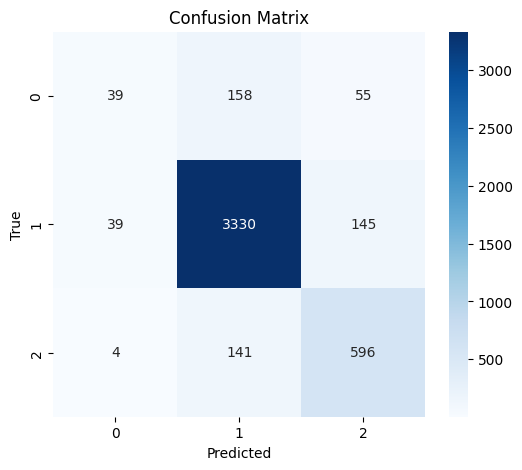

In [22]:
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [23]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     0.4756    0.1548    0.2335       252
           1     0.9176    0.9476    0.9324      3514
           2     0.7487    0.8043    0.7755       741

    accuracy                         0.8797      4507
   macro avg     0.7140    0.6356    0.6472      4507
weighted avg     0.8651    0.8797    0.8675      4507



In [24]:
# Log Loss
ll = log_loss(y_test, y_prob)
print("Log Loss:", ll)

Log Loss: 0.32478636662722965


In [25]:
# Multi-class ROC-AUC (One-vs-Rest)
lb = LabelBinarizer()
lb.fit(y_test)
y_test_binarized = lb.transform(y_test)

# Some versions of sklearn need average + multi_class args
auc_macro_ovr = roc_auc_score(
    y_test_binarized,
    y_prob,
    average="macro",
    multi_class="ovr"
)
print("ROC-AUC (macro, OvR):", auc_macro_ovr)

ROC-AUC (macro, OvR): 0.9053946781213398


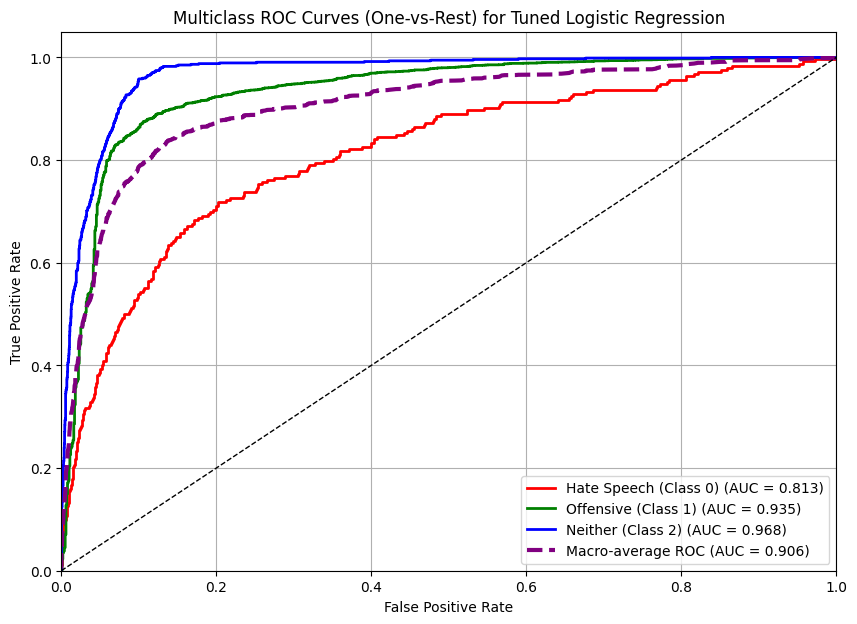

In [33]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
classes = [0, 1, 2]
y_test_bin = label_binarize(y_test, classes=classes)
y_proba = best_lr.predict_proba(X_test_final)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Macro-average AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(len(classes)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= len(classes)
roc_auc["macro"] = auc(all_fpr, mean_tpr)

plt.figure(figsize=(10, 7))

colors = ['red', 'green', 'blue']
labels = ['Hate Speech (Class 0)', 'Offensive (Class 1)', 'Neither (Class 2)']

for i, color in zip(range(len(classes)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"{labels[i]} (AUC = {roc_auc[i]:.3f})")

# Macro-average plot
plt.plot(all_fpr, mean_tpr,
         label=f"Macro-average ROC (AUC = {roc_auc['macro']:.3f})",
         color='purple', linestyle='--', linewidth=3)

plt.plot([0, 1], [0, 1], 'k--', lw=1)  # baseline diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curves (One-vs-Rest) for Tuned Logistic Regression")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# ============================================
# SIMPLE "MODEL DEPLOYMENT" – PREDICT ON NEW TWEETS
# ============================================

In [26]:
class_mapping = {
    0: "Hate Speech",
    1: "Offensive Language",
    2: "Neither"
}

def preprocess_new_tweets(raw_tweets):
    # raw_tweets: list of strings
    clean_tweets = [clean_text(t) for t in raw_tweets]
    length_feature = np.array([len(t) for t in clean_tweets]).reshape(-1, 1)

    # TF-IDF
    X_tfidf = tfidf.transform(clean_tweets)

    # SVD
    X_svd = svd.transform(X_tfidf)

    # Scale numeric features
    X_len_scaled = scaler.transform(length_feature)

    # Combine
    X_final = np.hstack([X_svd, X_len_scaled])

    return X_final

def predict_tweets(raw_tweets):
    X_final = preprocess_new_tweets(raw_tweets)
    preds = best_lr.predict(X_final)
    probs = best_lr.predict_proba(X_final)

    results = []
    for text, label, prob in zip(raw_tweets, preds, probs):
        results.append({
            "tweet": text,
            "predicted_class": int(label),
            "predicted_label": class_mapping[int(label)],
            "class_probabilities": {
                "hate_speech_0": prob[0],
                "offensive_1": prob[1],
                "neither_2": prob[2]
            }
        })
    return results

In [27]:
# EXAMPLE USAGE:
new_examples = [
    "I hate these people so much, they should disappear.",
    "I love this community, everyone is so kind.",
    "That guy is such an idiot, but whatever."
]

deployment_results = predict_tweets(new_examples)

for res in deployment_results:
    print("\nTweet:", res["tweet"])
    print("Predicted class:", res["predicted_class"], "-", res["predicted_label"])
    print("Probabilities:", res["class_probabilities"])


Tweet: I hate these people so much, they should disappear.
Predicted class: 0 - Hate Speech
Probabilities: {'hate_speech_0': np.float64(0.5676424941021749), 'offensive_1': np.float64(0.4100885322234815), 'neither_2': np.float64(0.022268973674343474)}

Tweet: I love this community, everyone is so kind.
Predicted class: 2 - Neither
Probabilities: {'hate_speech_0': np.float64(0.0622545490830674), 'offensive_1': np.float64(0.4616179775235148), 'neither_2': np.float64(0.4761274733934178)}

Tweet: That guy is such an idiot, but whatever.
Predicted class: 1 - Offensive Language
Probabilities: {'hate_speech_0': np.float64(0.14043780669905595), 'offensive_1': np.float64(0.5909284326242334), 'neither_2': np.float64(0.2686337606767106)}


# ============================================
# SAVE TRAINED ARTIFACTS (OPTIONAL, FOR REAL DEPLOYMENT)
# ============================================

In [28]:
joblib.dump(best_lr, "best_logistic_regression_model.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")
joblib.dump(svd, "svd_transformer.pkl")
joblib.dump(scaler, "length_scaler.pkl")

print("Model and transformers saved successfully.")

Model and transformers saved successfully.
